# PyTorch 모델 최적화: 과적합 방지와 학습 안정화

## 1. 과소적합, 적절한 학습, 과대적합

### 1.1 개념 설명

1. 과소적합 (Underfitting)

    - 모델이 데이터의 패턴을 제대로 학습하지 못하는 상태입니다.
    - 특징: 학습 데이터와 테스트 데이터 모두에서 높은 오차가 발생합니다.
    - 해결방법: 더 복잡한 모델을 사용하거나 학습률을 조정하고 학습 시간을 늘릴 수 있습니다.

2. 적절한 학습 (Good Fit)

    - 모델이 데이터의 패턴을 잘 학습한 상태입니다.
    - 특징: 학습 데이터와 테스트 데이터에서 적절한 수준의 오차를 보이며, 새로운 데이터에도 좋은 예측 성능을 가집니다.

3. 과대적합 (Overfitting)

    - 모델이 학습 데이터를 너무 잘 외워버려서 새로운 데이터에 대한 예측 성능이 떨어집니다.
    - 특징: 학습 데이터에서는 매우 낮은 오차를 보이지만, 테스트 데이터에서는 오차가 크게 발생합니다.
    - 해결방법: 정규화 기법을 사용하거나 드롭아웃을 추가하고, 데이터 증강을 통해 일반화 성능을 높일 수 있습니다.

### 1.2 과소적합, 적절한 학습, 과대적합 사례 시각화

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 데이터 생성 함수
def generate_data(n_samples=1000, noise=0.2):
    X = np.linspace(-3, 3, n_samples)
    y = 1.5 * np.sin(2 * X) + 0.5 * X**2 - 0.2 * X**3
    y += np.random.normal(0, noise, size=y.shape)
    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)
    return torch.FloatTensor(X), torch.FloatTensor(y)

In [3]:
# 모델 정의
class SimpleModel(nn.Module):
    def __init__(self, size='medium'):
        super(SimpleModel, self).__init__()
        if size == 'low':  # 과소적합 모델
            self.model = nn.Sequential(
                nn.Linear(1, 2), nn.ReLU(),
                nn.Linear(2, 1)
            )
        elif size == 'medium':  # 적절한 모델
            self.model = nn.Sequential(
                nn.Linear(1, 16), nn.ReLU(),
                nn.Linear(16, 64), nn.ReLU(),
                nn.Linear(64, 16), nn.ReLU(),
                nn.Linear(16, 1)
            )
        else:  # 과대적합 모델
            self.model = nn.Sequential(
                nn.Linear(1, 1024), nn.ReLU(),
                nn.Linear(1024, 2048), nn.ReLU(),
                nn.Linear(2048, 1024), nn.ReLU(),
                nn.Linear(1024, 512), nn.ReLU(),
                nn.Linear(512, 128), nn.ReLU(),
                nn.Linear(128, 1)
            )

    def forward(self, x):
        return self.model(x)

- SimpleModel

    - 모델의 복잡도를 결정할 수 있도록 설계한 클래스입니다. 'low'는 과소적합, 'medium'은 적절한 학습, 'high'는 과대적합 모델을 나타냅니다.

In [4]:
# 학습 함수
def train(model, X_train, y_train, X_test, y_test, epochs=500, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                test_pred = model(X_test)
                test_loss = loss_fn(test_pred, y_test)
                train_losses.append(loss.item())
                test_losses.append(test_loss.item())

    return train_losses, test_losses

- train: 모델을 학습시키는 함수로, 학습 및 테스트 데이터에 대한 손실 값을 기록합니다.

In [5]:
# 결과 시각화 함수
def plot_results(results):
    plt.figure(figsize=(15, 5))
    titles = ['Underfitting', 'Good Fit', 'Overfitting']

    for idx, (name, result) in enumerate(results.items(), 1):
        plt.subplot(1, 3, idx)
        plt.plot(result['train'], label='Train Loss', color='blue')
        plt.plot(result['test'], label='Test Loss', color='red')
        plt.title(titles[idx-1])
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

- plot_results: 학습 결과를 시각적으로 확인할 수 있는 함수입니다.

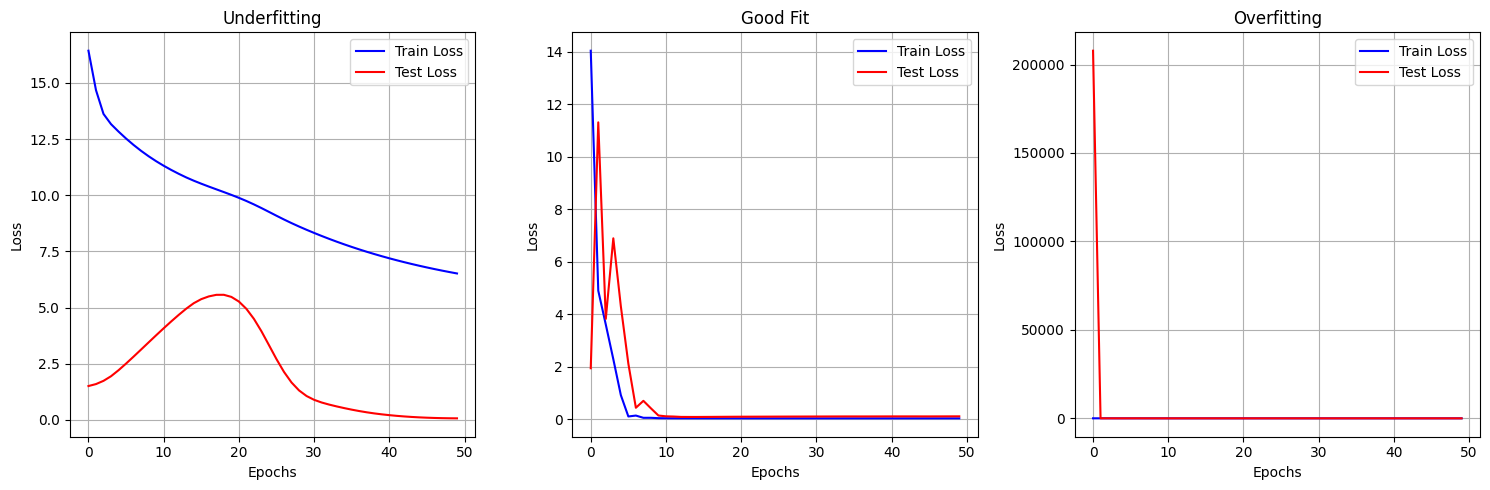

In [6]:
# 실험 실행
X, y = generate_data(n_samples=1000)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

models = {
    'Underfitting': SimpleModel('low'),
    'Good Fit': SimpleModel('medium'),
    'Overfitting': SimpleModel('high')
}

results = {}
for name, model in models.items():
    results[name] = {}
    train_loss, test_loss = train(model, X_train, y_train, X_test, y_test, epochs=500)
    results[name]['train'] = train_loss
    results[name]['test'] = test_loss

plot_results(results)

### 결과 해석

- Underfitting: 학습 및 테스트 손실이 모두 높아, 모델이 데이터의 패턴을 잘 학습하지 못했습니다.

- Good Fit: 학습 손실과 테스트 손실이 적절하게 낮으며, 모델이 데이터를 적절히 학습했습니다.

- Overfitting: 학습 손실은 매우 낮지만, 테스트 손실이 높아 모델이 학습 데이터를 과하게 외운 상태입니다.

## 2. 배치 정규화 (Batch Normalization)

### 2.1 개념 설명

- 배치 정규화는 각 레이어의 입력을 정규화하여 학습을 안정화시키고, 더 높은 학습률을 사용할 수 있도록 합니다. 이는 내부 공변량 이동(Internal Covariate Shift)을 줄여줍니다.

### 배치 정규화 코드

In [7]:
# 배치 정규화 적용
class ModelWithBN(nn.Module):
    def __init__(self):
        super(ModelWithBN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 64),
            nn.BatchNorm1d(64),  # 배치 정규화 추가
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),  # 배치 정규화 추가
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),  # 배치 정규화 추가
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)

In [8]:
# 배치 정규화 적용 X
class ModelWithoutBN(nn.Module):
    def __init__(self):
        super(ModelWithoutBN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
            )

    def forward(self, x):
        return self.network(x)

In [9]:
# 두 모델을 비교하고 결과를 시각화
def compare_batch_norm(X_train, y_train, X_test, y_test):
    models = {
        'With BatchNorm': ModelWithBN(),
        'Without BatchNorm': ModelWithoutBN()
    }

    results = {}
    for name, model in models.items():
        train_losses, test_losses = train(model, X_train, y_train, X_test, y_test, epochs=200)
        results[name] = {'train': train_losses, 'test': test_losses}

    # 결과 시각화
    plt.figure(figsize=(12, 5))
    for i, (name, res) in enumerate(results.items(), 1):
        plt.subplot(1, 2, i)
        plt.plot(res['train'], label='Train Loss')
        plt.plot(res['test'], label='Test Loss')
        plt.title(name)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

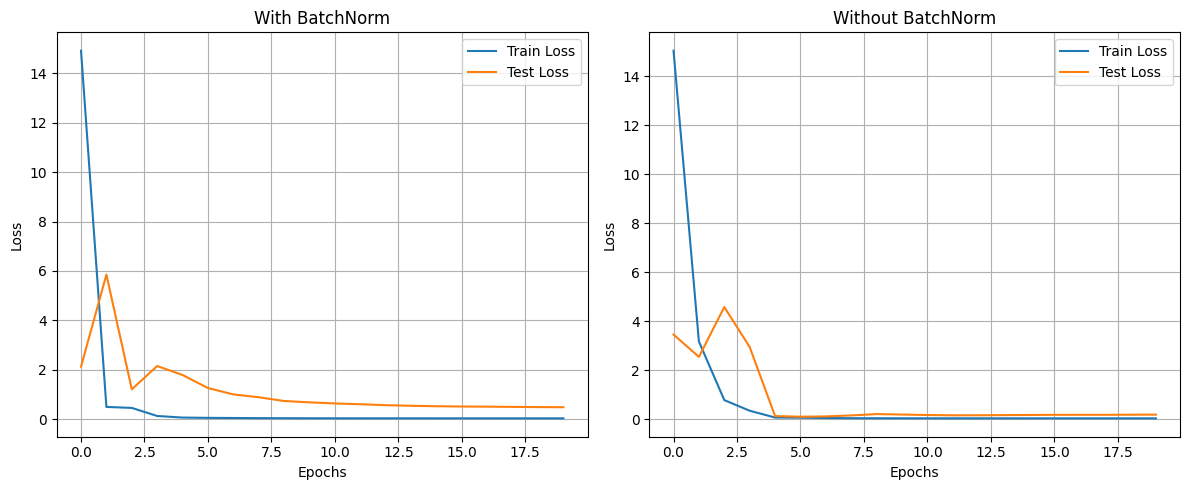

In [10]:
# 배치 정규화 실험 실행
compare_batch_norm(X_train, y_train, X_test, y_test)

### 결과 해석

- 배치 정규화를 적용한 모델이 더 빠르게 수렴하고, 학습 안정성이 개선된 모습을 보입니다.

## 3. 가중치 초기화


### 3.1 개념

가중치 초기화는 신경망 학습에서 중요한 첫 단계입니다. 가중치가 잘못 초기화되면 기울기 소실이나 폭발 현상이 일어나 학습이 제대로 이루어지지 않을 수 있습니다. 다양한 초기화 방법을 통해 이러한 문제를 해결할 수 있습니다.

- Xavier 초기화 (Glorot 초기화)

    - 주로 시그모이드 함수나 하이퍼볼릭 탄젠트 함수와 함께 사용되며, 가중치의 분포를 적절히 설정해 기울기 소실을 방지합니다.

- Kaiming 초기화 (He 초기화)

    - ReLU와 같은 비선형 활성화 함수에서 주로 사용되며, 각 뉴런의 활성화 확률을 조정하여 기울기 폭발을 방지합니다.

- Zero 초기화

    - 가중치를 모두 0으로 설정하는 방식인데, 학습이 거의 이루어지지 않으므로 권장되지 않습니다.

### 3.2 가중치 초기화 코드

In [ ]:
# 데이터를 생성
np.random.seed(42)
torch.manual_seed(42)
X = np.linspace(-3, 3, 1000).reshape(-1, 1)
y = 1.5 * np.sin(2 * X) + 0.5 * X**2 - 0.2 * X**3 + np.random.normal(0, 0.2, size=X.shape)
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

In [ ]:
# 학습 데이터를 80%, 테스트 데이터를 20%로 분리
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# 초기화 방법에 따른 신경망 모델 생성 및 학습
class SimpleModel(nn.Module):
    def __init__(self, init_method='default'):
        super(SimpleModel, self).__init__()
        self.linear1 = nn.Linear(1, 64)
        self.linear2 = nn.Linear(64, 1)

        # 가중치 초기화 방식 선택
        if init_method == 'xavier':
            nn.init.xavier_normal_(self.linear1.weight)
            nn.init.xavier_normal_(self.linear2.weight)
        elif init_method == 'kaiming':
            nn.init.kaiming_normal_(self.linear1.weight)
            nn.init.kaiming_normal_(self.linear2.weight)
        elif init_method == 'zeros':
            nn.init.zeros_(self.linear1.weight)
            nn.init.zeros_(self.linear2.weight)

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        return self.linear2(x)

- InitModel

    - 신경망 모델을 정의하고, 생성 시 다양한 초기화 방법을 적용할 수 있도록 설계된 클래스입니다.

    - Xavier 초기화는 nn.init.xavier_normal_ 함수를 통해 가중치를 적절히 초기화하여 기울기 소실 문제를 방지합니다.

    - Kaiming 초기화는 nn.init.kaiming_normal_ 함수로 ReLU 활성화 함수에 최적화된 가중치 분포를 생성합니다.

    - Zero 초기화는 가중치를 모두 0으로 설정하는 비효율적인 방법입니다.

In [ ]:
# 학습 함수
def train_and_plot(init_method):
    # 모델 생성 및 초기화
    model = SimpleModel(init_method=init_method)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    train_losses = []
    test_losses = []

    # 100 에포크 동안 학습
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                test_output = model(X_test)
                test_loss = criterion(test_output, y_test)
            train_losses.append(loss.item())
            test_losses.append(test_loss.item())

    # 결과 시각화
    epochs = range(0, 100, 10)
    plt.plot(epochs, train_losses, label=f'{init_method} Train Loss')
    plt.plot(epochs, test_losses, label=f'{init_method} Test Loss', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

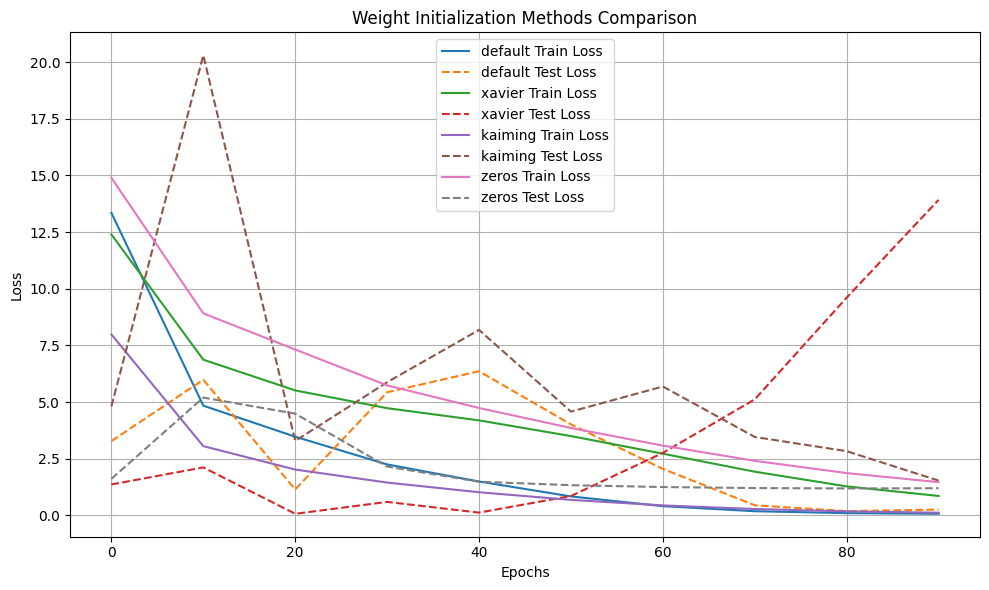

In [ ]:
# 각 초기화 방법별 학습 결과 비교
plt.figure(figsize=(10, 6))

# 기본 초기화 (default)
train_and_plot('default')

# Xavier 초기화
train_and_plot('xavier')

# Kaiming 초기화
train_and_plot('kaiming')

# Zero 초기화
train_and_plot('zeros')

plt.title('Weight Initialization Methods Comparison')
plt.tight_layout()
plt.show()

- 결과 해석

    - Xavier 초기화

        - 비선형 데이터에 적합한 초기화 방법으로, 학습 속도와 성능이 안정적입니다.

    - Kaiming 초기화
    
        - ReLU 활성화 함수에 최적화된 초기화 방법으로, 깊은 네트워크에서도 안정적인 학습을 보장합니다.

    - Zero 초기화
    
        - 가중치를 모두 0으로 설정하면, 학습이 제대로 이루어지지 않으며 성능이 매우 낮습니다. 이는 모든 뉴런이 동일한 가중치를 학습하기 때문에 발생하는 문제입니다.

### 학습 실습 과제

1. **과적합 실험**
   - 데이터 크기를 변경하며 과적합 정도 관찰해보세요.
   - 또한, 모델 복잡도와 과적합의 관계도 분석해보세요.

2. **배치 정규화 실험**
   - 배치 정규화 유무에 따른 학습 성능 변화를 비교하세요.

3. **가중치 초기화 실험**
   - 다양한 초기화 방법을 적용하여 학습 성능을 비교하고, 각 초기화 방법의 장단점을 분석하세요.

### 주의사항
- 배치 정규화는 배치 크기가 1일 때 사용 불가
- 가중치 초기화는 모델 구조에 따라 적절한 방법 선택
- 과적합 방지를 위해 여러 기법 조합 필요

## 참고자료
- [PyTorch BatchNorm 문서](https://pytorch.org/docs/stable/nn.html#batchnorm1d)
- [PyTorch 가중치 초기화 가이드](https://pytorch.org/docs/stable/nn.init.html)